# Regression

So far our target has always been of categorical type. However, it is very likely that one encounters situations where the target is continuous. We shall limit ourselves for now to cases where we try to predict using item $\mathbf{x}$ the target value $y \in \mathbb{R}$. Since most have already been in courses of statistics you guessed it - we shall be first doing linear regression, but soon present TreeRegreesor and random forest regressors. 

In [4]:
# Import the required libraries
import pandas as pd # Pandas deals with handling data. 
import numpy as np # Numpy provides a lot of FAST ways for array manipulation in python.
import matplotlib.pyplot as plt # Plotting script library
import matplotlib as mpl # Plotting
import seaborn as sns # More plotting

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".99"})
sns.set_style("ticks")

data = sns.load_dataset('penguins')
target = 'species'
xlabel = 'bill_length_mm'
ylabel = 'bill_depth_mm'

### Training supervised regressor using scikit-learn:

#### Regression:
The task is to predict the probability density of value $\mathbf{y}$ for given regressor $\mathcal{G}(\mathbf{x}) = p(\mathbf{y})$. That is, regressor $\mathcal{G}: \mathcal{F} \rightarrow  [0, 1]^{\text{dim}(y)}$.  

Training a model is the process where you use the training data $(\mathbf{X}_\text{train}, \mathbf{y}_\text{train})$ to modify parameters of the model $\mathcal{M}$ so that you expect the resulting model somehow capture the underlying true function $f$. For knn classifier training meant only to provide the training data and the class labels, but this process can be obviously more elaborate. 

The second simplest thing is to consider linear regression. We can take a single species from the data **Gentoo** and see if we can estimate the 'bil_depth' using the 'bil length'.

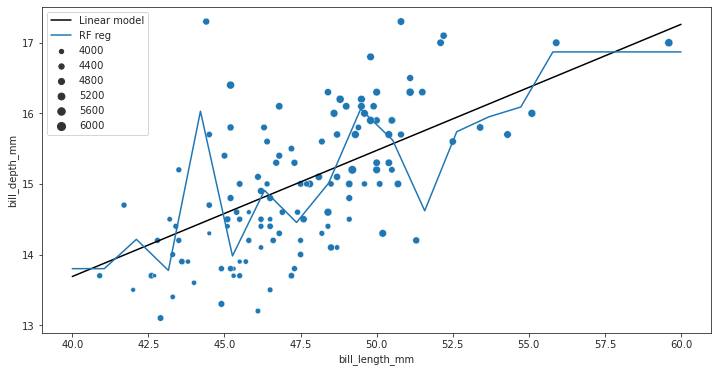

In [5]:
# select only single species from the data
species = 'Gentoo'
mask = data.species == species

# Import the linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


X = data.loc[mask, xlabel].values.reshape(-1, 1)
y = data.loc[mask, ylabel]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.5)

# We fit the linear model to training data:
linreg = LinearRegression().fit(X_train, y_train)
rfreg = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)

ax = sns.scatterplot(data=data[mask], x=xlabel, y=ylabel, size='body_mass_g')
xrange = np.linspace(40, 60, 20)
ax.plot(xrange, linreg.coef_[0]*xrange + linreg.intercept_, color='black', label='Linear model')
ax.plot(xrange, rfreg.predict(xrange.reshape(-1, 1)), label='RF reg')
_ = plt.legend()

The 'predictions' given by the regressor (linreg) are shown as the black line. We shall not dwell into scoring of such a fit, but note that notice how here 'machine learning' reminds quite a bit of traditional statistics. What separates ML from regular modeling that most of the time you do not care to *understand* the system or the system is so complicated that it is completely impossible to find reasonable models (consider for example image recognition). However, it is not too rare that a given ML task can be solved by simple methods with the added benefit that usually those methods are also easier (or at least possible) to interpret see: https://community.fico.com/s/blog-post/a5Q2E0000001czyUAA/fico1670 